In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os
from pandas.core.dtypes.common import is_numeric_dtype
from sklearn.preprocessing import MinMaxScaler

import default_style

In [2]:
DATA_FOLDER = 'dataset'
DATASET = os.path.join(DATA_FOLDER, 'preprocessed_df.csv')
LABELLED_OUTLIERS = os.path.join(DATA_FOLDER, 'outliers_labelled.csv')
OUTLIERS_REMOVED = os.path.join(DATA_FOLDER, "outliers_removed.csv")

In [3]:
df = pd.read_csv(DATASET)
numerical_attr_list = [col for col in df.columns if is_numeric_dtype(df[col])]
categorical_attr_list = [col for col in df.columns if not is_numeric_dtype(df[col])]

In [4]:
# Color codes
code_map = dict(not_outlier="k", ABOD="g", LOF="r", ISFO="b", aggregatedOD="orange")

## Preliminary

In [5]:
# Redefine some stuff of used OD classes
# to obtain code continuity
from sklearn.neighbors import LocalOutlierFactor
from pyod.models.abod import ABOD
from sklearn.ensemble import IsolationForest

class MyLOF(LocalOutlierFactor):
    name = "LOF"

    @property
    def scores(self): return self.negative_outlier_factor_

class MyABOD(ABOD):
    name = "ABOD"

    @property
    def scores(self): return self.decision_scores_

class MyISFO(IsolationForest):
    name = "ISFO"

    def fit(self, X):
        self._train_samp = X
        return super().fit(X)
    
    @property
    def scores(self): return self.score_samples(self._train_samp)

In [6]:
# Defines an aggregated OD method
from sklearn.preprocessing import MinMaxScaler

class AggregatedOD(object):
    name = "aggregatedOD"
    def __init__(self, coefficient_vector=None, **pars):
        self.methods = []
        self.single_scores = None
        self._scores = None

        if coefficient_vector is None:
            coefficient_vector = np.ones(3)/3
        else:
            self.coefficient_vector = np.array(coefficient_vector)/np.sum(coefficient_vector)

        for od_meth in [MyISFO, MyABOD, MyLOF]:
            self.methods.append(od_meth(** (pars.get(od_meth.name, dict() ))))
        
    def fit(self, X):
        for od_meth in self.methods:
            od_meth.fit(X)
        self.scores

    @property
    def scores(self):
        self.single_scores = [MinMaxScaler().fit_transform(od_meth.scores.reshape(-1,1)).reshape(-1) for od_meth in self.methods]
        self.single_scores = np.array(self.single_scores)
        self._scores = self.coefficient_vector[None, :].dot(self.single_scores).reshape(-1)
        return self._scores
    
    def make_table(self, p_percent=0.01):
        assert 0.0 < p_percent < 1.0, "percent must be smaller than one and bigger than zero"
            
        if self._scores is None:
            raise RuntimeError("AggregatedOD must be fitted to something before taking the worst points")
        
        # Builds a score table for each method
        score_table = pd.DataFrame(
                                    self.single_scores.T, 
                                    columns=[f"{meth.name}_score" for meth in self.methods]
                                  )
        
        # Adds the aggregated scoring
        score_table = score_table.join(
                                        pd.DataFrame(
                                                    self._scores.T, 
                                                    columns=[f"{self.name}_score"]
                                                    )
                                        )
        # Computes the actual number of points to be identified
        N_p  = int(p_percent*len(self._scores))
        
        for od_meth in self.methods + [self]:
            score_table[f"is_{od_meth.name}_outlier"] = False
            bad_kids = score_table[f"{od_meth.name}_score"].nsmallest(N_p).index
            score_table.loc[bad_kids, f"is_{od_meth.name}_outlier" ] = True
        return score_table

Defines the subsamples in which to fine outliers

In [7]:
# The sub-samples in which the dataset is divided
# Currently the OD is performed on each element of (vocal_channel, sex) product category
locality_areas = []
for vc in ["song", "speech"]:
    for s in ["M","F"]:
        locality_areas.append(dict(vocal_channel=vc, sex=s))

## FInd outliers

For each method finds the top `p%` outliers

In [8]:
params = dict(ISFO=dict(n_jobs=-1, n_estimators=100),
              ABOD=dict(),
              LOF =dict(n_jobs=-1), ) # Parameters of the estimators

outlier_detector = AggregatedOD(coefficient_vector=[0.3, 1,1], **params)
methods =  outlier_detector.methods + [outlier_detector]

for locality in locality_areas:
    
    # Takes the local subsample
    locality_mask = np.array([(df[key] == val).values for key, val in locality.items()]).all(axis=0)
    
    # Normalizes the subsample with MinMaxScaler
    subsamp = MinMaxScaler().fit_transform( df.loc[locality_mask][numerical_attr_list])
    
    # Fits
    outlier_detector.fit(subsamp)
   
    # Takes the worsts
    score_table = outlier_detector.make_table(p_percent=0.01)
    
    # Sets the values in the original dataset
    for od_meth in methods:
        df.loc[locality_mask, f"is_{od_meth.name}_outlier"] =  score_table[f"is_{od_meth.name}_outlier"].values
        df.loc[locality_mask, f"{od_meth.name}_score"] = score_table[f"{od_meth.name}_score"].values

# Finally assign colors
df["outlier_color"] = code_map["not_outlier"]
for meth in methods:
    df.loc[df[f"is_{meth.name}_outlier"], "outlier_color"] = code_map[meth.name]

In [9]:
outliers_found = [df[f"is_{od_meth.name}_outlier"].sum() for od_meth in methods]
outliers_found

[23, 23, 23, 23]

Now check whether the outliers have a predominant category

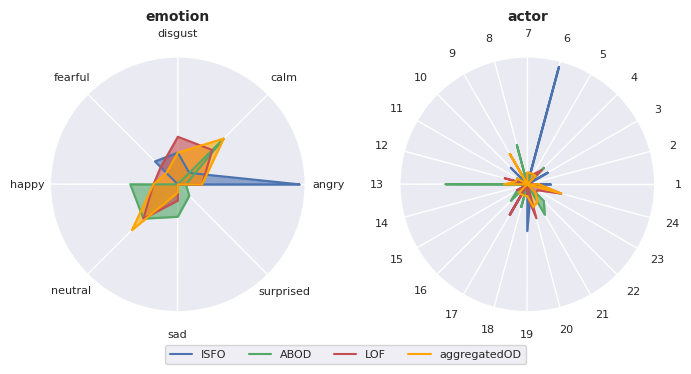

In [23]:
def plot_polar_closed(items, r, ax, **kwargs):
    items = list(items)
    asort = np.argsort(items)

    items = np.array(items)[asort]
    r = np.array(list(r))[asort]

    theta = np.linspace(0, 6.28, len(items), endpoint=False)

    theta = np.append(theta, theta[0])
    r = np.append(r, r[0])
    fill_kwargs = kwargs.copy()
    fill_kwargs["alpha"] = 0.6,
    fill_kwargs["label"] = ""

    ax.fill_between(theta,0*r, r, **fill_kwargs)
    ax.plot(theta, r, **kwargs)

    ax.set_xticks(theta[:-1], items, fontsize=8)
    ax.set_rticks([])

fig, axes = plt.subplots(1,2, figsize=default_style.FULLSIZE_FIGURE, 
                         subplot_kw={'projection': 'polar'})

for i, cat in enumerate(["emotion", "actor"]):
    cat_vals, cat_counts = np.unique(df[cat], return_counts=True)
    if cat =="actor":
        cat_vals = [int(act_name.split("_")[1]) for act_name in cat_vals]
    cat_counts = cat_counts/np.sum(cat_counts)

    for meth in methods:
        outlying_items, counts_num = np.unique(df.loc[df[f"is_{ meth.name}_outlier"], cat], return_counts=True)
        counts_num = counts_num/np.sum(counts_num)
        if cat == "actor":
            outlying_items = [int(act_name.split("_")[1]) for act_name in outlying_items]

        counts = {c:0 for c in np.unique(cat_vals)}
        for outlying_item, out_count, cc in zip(outlying_items, counts_num, cat_counts):
            # Normalize on category count
            # e.g.: More values of fear --> more outliers of fear
            counts[outlying_item] = out_count/cc

        plot_polar_closed(counts.keys(), counts.values(), axes[i], label=i*"_" + meth.name, color=code_map[meth.name])

# Cutieries
axes[0].set_title("emotion", fontsize=10);
axes[1].set_title("actor", fontsize=10);

# Places a shared legend under the plot
fig.legend(loc="lower center", bbox_to_anchor = (0.5,-0.05), ncols=4)

# plt.subplots_adjust(wspace=0.35, bottom=0.17)
fig.tight_layout()
plt.savefig("images/outliers_categories.pdf")

In [11]:
# binary_categories = ["emotional_intensity",  "statement", "repetition", "sex", "vocal_channel",]
# fig, axes = plt.subplots(1, len(binary_categories), figsize=FULLSIZE_FIGURE, sharey=True)
# for cat, ax in zip(binary_categories, axes):
#     small_df = pd.DataFrame()
#     for meth in methods:
#         o_values, o_counts = np.unique(df.loc[df[f"is_{meth.name}_outlier"], cat], return_counts = True)
#         a_values, a_counts = np.unique(df[cat], return_counts = True)
#         small_df = pd.concat([small_df, pd.DataFrame(dict(  method=[meth.name]*len(a_values), 
#                                                             cat=cat,
#                                                             rel_counts=o_counts/a_counts,
#                                                             attr=a_values))])
        
#     obj = sns.barplot(data=small_df,  x="method", y="rel_counts", ax=ax, hue="attr", alpha=0.8)
#     ax.legend([], [], frameon=False)
#     ax.set_title(cat)
#     ax.set_ylabel("")
# plt.tight_layout()
# plt.savefig("images/outliers_categories_2.pdf")

As it was expected, for sex and vocal channel the number of outliers for each value of the categorical attribute is approximately equal (by construction).
Emotional intensity is the most unbalanced categorical attribute, since one value of the categorical attribute is mostly categorized as outlier

## Accordance and scores

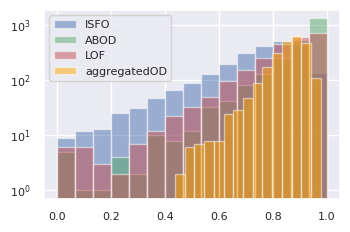

In [12]:
fig, ax = plt.subplots(figsize=default_style.SHORT_HALFSIZE_FIGURE)

for col in [u for u in df.columns if u.endswith("score")]:
    meth = col.split("_")[0]
    plt.hist(df[col], bins=15, alpha=0.5, color=code_map[meth], label=meth)
plt.legend(fontsize=8)
plt.yscale("log")

plt.tight_layout()
plt.savefig("images/outliers_score_hist.pdf")

Distribution of the normalized scores for each method. It can be seen that ABOD categorizes many records as surely inliers (high peak near score=1) while ISFO is has much less certain inliers.
The aggregated score takes this uncertainty in account (almost no records in the high scoring region). Clearly, the minimum of the score is higher (about 0.4) since it is the min of the sum of non-negative entries.

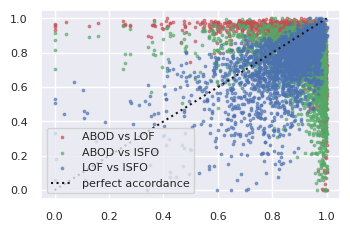

In [13]:
fig, ax = plt.subplots(figsize=default_style.SHORT_HALFSIZE_FIGURE)

plt.scatter(df["ABOD_score"], df["LOF_score"],label="ABOD vs LOF", color="r",s=3, alpha=0.6)
plt.scatter(df["ABOD_score"], df["ISFO_score"],label="ABOD vs ISFO",color="g", s=3, alpha=0.6)
plt.scatter(df["LOF_score"], df["ISFO_score"],label="LOF vs ISFO",color="b", s=3, alpha=0.6)

plt.plot(np.linspace(0,1), np.linspace(0,1), ls=":", color="k", label="perfect accordance")
plt.legend(fontsize=8)

plt.tight_layout()
plt.savefig("images/outliers_agreement.pdf")

Accordance between outliers. For perfect OD methods one would obtain only 0(outlier) and 1 (inlier) score values.

Since methods are uncertain, values are distributed. If each method was in perfect accordance with each other, scores would distribute around the bisecting line of the plane, since if one method categorizes a record to be an outlier (score near zero), other methods would give it a score near to zero too.

It can be seen that LOF and ISFO are in near accordance while ABOD is not in accordance with each other, since there are points in regions near (0, 1) (ABOD says outlier, LOF says inlier) and vice-versa.

## Check into an embedding

In [14]:
from sklearn.manifold import Isomap
from umap import UMAP

umap_reducer = UMAP(n_components=2, n_neighbors=100)
umap_embedding = umap_reducer.fit_transform(MinMaxScaler().fit_transform(df[numerical_attr_list]))

isomap_reducer = Isomap(n_components=2, n_neighbors=15)
isomap_embedding = isomap_reducer.fit_transform(MinMaxScaler().fit_transform(df[numerical_attr_list]))

/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/paolomollica/Desktop/DM2/venv/lib/python3.9/site-packages/uma

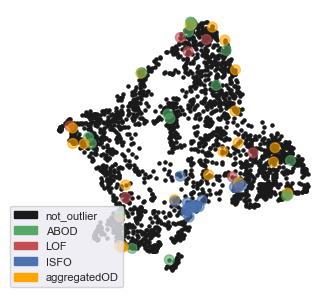

In [15]:
fig, ax = plt.subplots(figsize=default_style.HALFSIZE_FIGURE)
plt.scatter(*umap_embedding.T, color="k", s=5)
plt.scatter(*(umap_embedding[df.outlier_color != "k"]).T, c=df.outlier_color[df.outlier_color != "k"], alpha=0.6, s=50)

from matplotlib.patches import Patch
leg_handles, leg_lab = [], []
for k,v in code_map.items():
    leg_handles.append(Patch(color=v))
    leg_lab.append(k)
plt.legend(leg_handles, leg_lab, fontsize=8, bbox_to_anchor=(0.3,0.3));
plt.axis("off")
plt.savefig("images/outliers_embedding.pdf")

The blue region (ISFO outliers) prevalently belongs to anger. That region is much less dense than the others, but UMAP is built to consder the multidimensional manifold to be uniform, so it maps them in a mostly uniform region of space of the embedding.

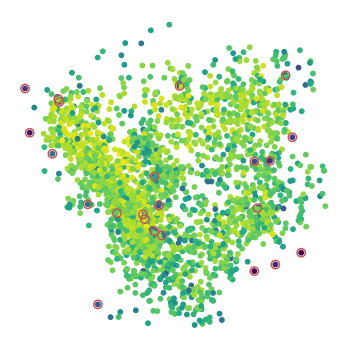

In [16]:
fig, ax = plt.subplots(figsize=default_style.HALFSIZE_FIGURE)

plt.scatter(*isomap_embedding.T, c=df.aggregatedOD_score, cmap="viridis", s=10)

mask = df["is_aggregatedOD_outlier"].values.astype(bool)

plt.scatter(*(isomap_embedding[mask].T), facecolors='none', edgecolors='r', marker="o")

plt.axis("off")

plt.tight_layout()
plt.savefig("images/outliers_killed_in_embeding.pdf")

bluer means more outlier. red crosses are the chosen one percent of worst outliers

## Save results

In [17]:
df = df.reset_index(drop=True)
df.to_csv(LABELLED_OUTLIERS, index=False)

# Remove outliers
df_outliers_removed = df.copy()
df_outliers_removed = df_outliers_removed.drop(columns=["is_ABOD_outlier", "is_ISFO_outlier", "is_LOF_outlier", "ABOD_score", "ISFO_score", "LOF_score", "outlier_color"] )
df_outliers_removed = df_outliers_removed.loc[np.logical_not(df_outliers_removed.is_aggregatedOD_outlier)]
df_outliers_removed = df_outliers_removed.drop(columns=["is_aggregatedOD_outlier", "aggregatedOD_score"])
df_outliers_removed.to_csv(OUTLIERS_REMOVED, index=False)

In [18]:
df_outliers_removed.columns.values

array(['vocal_channel', 'emotion', 'emotional_intensity', 'statement',
       'repetition', 'actor', 'sex', 'frame_count', 'sum', 'mean', 'std',
       'min', 'max', 'q01', 'q05', 'q25', 'q75', 'q95', 'q99', 'kur',
       'skew', 'lag1_q25', 'lag1_q75', 'lag1_skew', 'zc_sum', 'zc_mean',
       'zc_std', 'zc_kur', 'zc_skew', 'mfcc_sum', 'mfcc_mean', 'mfcc_std',
       'mfcc_min', 'mfcc_max', 'mfcc_q01', 'mfcc_q05', 'mfcc_q25',
       'mfcc_q50', 'mfcc_q75', 'mfcc_q95', 'mfcc_q99', 'mfcc_kur',
       'mfcc_skew', 'sc_sum', 'sc_mean', 'sc_std', 'sc_min', 'sc_max',
       'sc_q01', 'sc_q05', 'sc_q25', 'sc_q50', 'sc_q75', 'sc_q95',
       'sc_q99', 'sc_kur', 'sc_skew', 'stft_sum', 'stft_mean', 'stft_std',
       'stft_min', 'stft_q01', 'stft_q05', 'stft_q25', 'stft_q50',
       'stft_q75', 'stft_kur', 'stft_skew', 'length_w1', 'sum_w1',
       'std_w1', 'q05_w1', 'kur_w1', 'skew_w1', 'lag1_sum_w1',
       'lag1_max_w1', 'lag1_q95_w1', 'lag1_kur_w1', 'lag1_skew_w1',
       'zc_mean_w1', 'mfc